In [1]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib as mpl
import tensorflow as tf
import tensorflow_probability as tfp
from tqdm import tqdm_notebook as tqdm

from mbptycho.code.simulation import reloadSimulation
from skimage.feature import register_translation
from scipy import io
from mbptycho.code.recons.recons import DisplacementFullModelReconstruction
import copy
import os
base_path = os.environ['HOME']

gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.set_visible_devices(gpus[0], 'GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)
tf.config.set_soft_device_placement(False)


cmap = copy.copy(mpl.cm.get_cmap('coolwarm'))
cmap.set_bad('black')

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
tf.config.get_soft_device_placement()

False

In [4]:
!pwd

/home/skandel/code/mbptycho/mbptycho/tests/point_inclusions_sparse_scan/apodized_probe_weak_peaks


In [5]:
strain_type = 'point_inclusion'
data_path =  f'{base_path}/code/mbptycho/experiments/python/{strain_type}_sparse/apodized_probe_weak_peaks/'
sim_data_path = f'{data_path}/sim_{strain_type}.pkl'
sample_data_path = f'{data_path}/sample_{strain_type}.pkl'

save_plots = False

In [6]:
!ls $sim_data_path

/home/skandel/code/mbptycho/experiments/python/point_inclusion_sparse/apodized_probe_weak_peaks//sim_point_inclusion.pkl


In [7]:
sm = reloadSimulation(sim_data_path, reload_sim=True)#sim_params={"HKL_list":[[1, 2, 0]]}
sm.sample.Ux_trunc.shape, sm.sample.params.sample_pix_size

File exists. Reloading...


((200, 200, 20), 0.005844363636363636)

## Directly reconstructing the displacements

In [8]:
recons = DisplacementFullModelReconstruction(simulation=sm, shared_magnitudes=True, unwrap_phase_proj=True, batch_size=50)

Setting background_level to 1e-08...


In [9]:
disp_lr = 1e-2
magnitude_lr = 1e-1
if not 'ux_uy_2d_v' in recons.optimizers:
    recons.setDisplacementAdamOptimizer(disp_lr)
else:
    recons.optimizers['ux_uy_2d_v']['learning_rate'].assign(disp_lr)

if not 'magnitudes_log_v' in recons.optimizers:
    recons.setMagnitudeLogAdamOptimizer(magnitude_lr)
else:
    recons.optimizers['magnitudes_log_v']['learning_rate'].assign(magnitude_lr)

recons.optimizers

{'ux_uy_2d_v': {'learning_rate': <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=0.01>,
  'optimizer': <tensorflow.python.keras.optimizer_v2.adam.Adam at 0x7ff9cc312e50>,
  'var': <tf.Variable 'ux_uy:0' shape=(27930,) dtype=float32, numpy=array([1., 1., 1., ..., 1., 1., 1.], dtype=float32)>},
 'magnitudes_log_v': {'learning_rate': <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=0.1>,
  'optimizer': <tensorflow.python.keras.optimizer_v2.adam.Adam at 0x7ff9cc312d90>,
  'var': <tf.Variable 'magnitudes_log_v:0' shape=(13968,) dtype=float32, numpy=
  array([-16.118095, -16.118095, -16.118095, ..., -16.118095, -16.118095,
         -16.118095], dtype=float32)>}}

In [ ]:
recons.minimize(500, debug_output_epoch_frequency=1)

Initializing the datalog...
Instructions for updating:
This op will be removed after the deprecation date. Please switch to tf.sets.difference().
       epoch  train_loss     err_ux     err_uy  err_ux_film  err_uy_film   err_rho0   err_rho1   err_rho2   err_rho3  err_rho_film0  err_rho_film1  err_rho_film2  err_rho_film3
6          1    3.23e+05       0.91          1        0.897        0.999      0.816      0.948      0.958      0.942          0.773          0.935          0.952          0.927
12          2   3.96e+05      0.881      0.999      0.865          1      0.781      0.935      0.949      0.933      0.731      0.919      0.942      0.911
18          3   2.95e+05      0.867      0.997      0.849      0.999      0.764      0.927      0.943      0.935      0.714      0.908      0.938       0.91
24          4   3.78e+05      0.861      0.996      0.843          1      0.756      0.929      0.943      0.941      0.719       0.91      0.938      0.921
30          5   3.64e+05     

In [ ]:
plt.plot(recons.datalog.dataframe.train_loss.dropna())
plt.yscale('log')

In [63]:

true_items = {}
recons_items = {}

if recons._model_type != 'phase':
    recons_items[r"$\alpha_x$"] = recons.ux_2d - recons.ux_2d.mean() 
    true_items[r"$\alpha_x$"] = recons._ux_true - recons._ux_true.mean() 

    recons_items[r"$\alpha_y$"] = recons.uy_2d - recons.uy_2d.mean()
    true_items[r"$\alpha_y$"] = recons._uy_true - recons._uy_true.mean()


if not recons._model_type == 'displacement_to_phase':

    for i in range(recons.rho_2d.shape[0]):
        phase_label = ''.join(sm.params.HKL_list[i].astype('str'))
        labelstr = rf"$\phi$({phase_label})"
        
        rollr, errr, phaser = register_translation( recons._rho_true[i], recons.rho_2d[i], upsample_factor=10)
        recons_items[labelstr] = np.angle(recons.rho_2d[i] * np.exp(1j * phaser))
        true_items[labelstr] = np.angle(recons._rho_true[i])

/home/skandel/miniconda3/envs/tf2/lib/python3.8/site-packages/skimage/feature/__init__.py:45: skimage_deprecation: Function ``register_translation`` is deprecated and will be removed in version 0.19. Use ``skimage.registration.phase_cross_correlation`` instead.
  removed_version='0.19')
/home/skandel/miniconda3/envs/tf2/lib/python3.8/site-packages/skimage/feature/__init__.py:45: skimage_deprecation: Function ``register_translation`` is deprecated and will be removed in version 0.19. Use ``skimage.registration.phase_cross_correlation`` instead.
  removed_version='0.19')
/home/skandel/miniconda3/envs/tf2/lib/python3.8/site-packages/skimage/feature/__init__.py:45: skimage_deprecation: Function ``register_translation`` is deprecated and will be removed in version 0.19. Use ``skimage.registration.phase_cross_correlation`` instead.
  removed_version='0.19')
/home/skandel/miniconda3/envs/tf2/lib/python3.8/site-packages/skimage/feature/__init__.py:45: skimage_deprecation: Function ``register_t

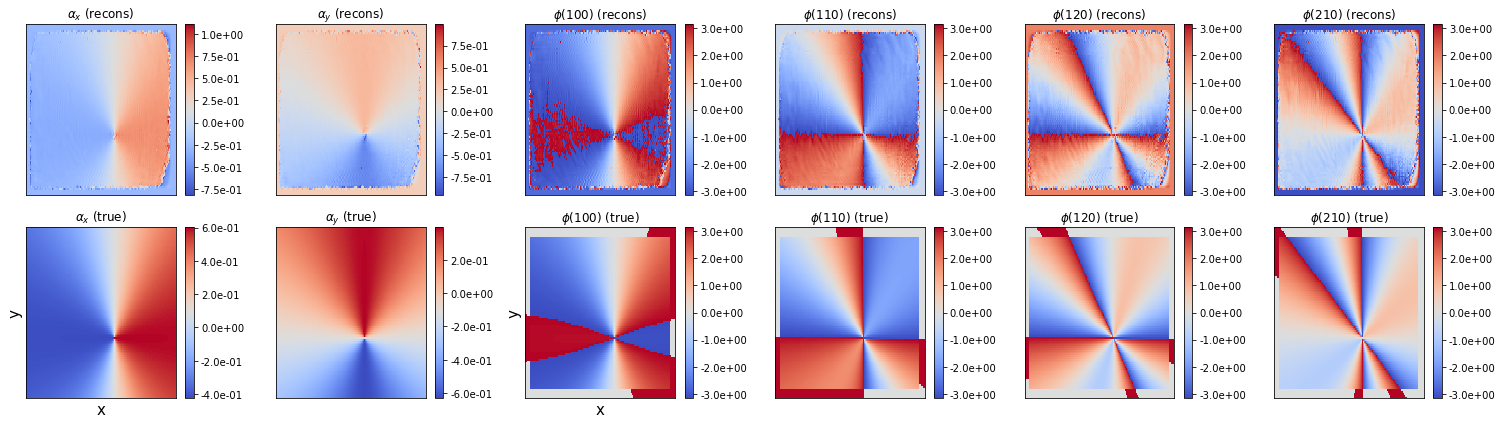

In [64]:
save_plots = False
if recons._model_type == 'phase':
    subplots_x = recons.rho_2d.shape[0] 
    figsize_x = subplots_x * 3.5
elif recons._model_type == 'displacement_to_phase':
    figsize_x = 8
    subplots_x = 2
else:
    subplots_x = (recons.rho_2d.shape[0] + 2) 
    figsize_x = subplots_x * 3.5

recons_suffix = recons._model_type

    
fig, axs = plt.subplots(2, subplots_x, figsize=[figsize_x, 6]) 
for i, (key, value) in enumerate(recons_items.items()):
    if i == 0 and recons._model_type != 'phase':
        vmin=-2.1
        vmax = 2.1
    elif i == 1 and recons._model_type!= 'phase':
        vmin = -0.21
        vmax = 0.21
    else:
        vmin = -np.pi
        vmax = np.pi
    
    #value[~(sm.sample.amplitudes_trunc_mask[pady0: pady0 + nyvar, padx0: padx0 + nxvar, nzvar//2])] = np.nan
    cp0 = axs[0, i].pcolormesh(value, cmap='coolwarm')#, vmin=vmin, vmax=vmax)
    axs[0, i].set_title(key + " (recons)")
    axs[0, i].set_xticks([])
    axs[0, i].set_yticks([])
    plt.colorbar(cp0, ax=axs[0, i], format="%2.1e")
    
    true_value = true_items[key] 
    #true_value[~(sm.sample.amplitudes_trunc_mask[pady0: pady0 + nyvar, padx0: padx0 + nxvar, nzvar//2])] = np.nan
    cp1 = axs[1, i].pcolormesh(true_items[key], cmap='coolwarm')#, vmin=vmin, vmax=vmax)
    axs[1, i].set_title(key + " (true)")
    plt.colorbar(cp1, ax=axs[1, i], format="%2.1e")
    axs[1, i].set_xticks([])
    axs[1, i].set_yticks([])
    
axs[1,0].set_xlabel('x', fontsize=15)
axs[1,0].set_ylabel('y', fontsize=15)

if not recons._model_type=='displacement_to_phase':
    axs[1,2].set_xlabel('x', fontsize=15)
    axs[1,2].set_ylabel('y', fontsize=15)


plt.tight_layout()

if save_plots:
    
    plt.savefig(f'{data_path}_recons_{recons_suffix}.png', bbox_inches='tight')
plt.show()

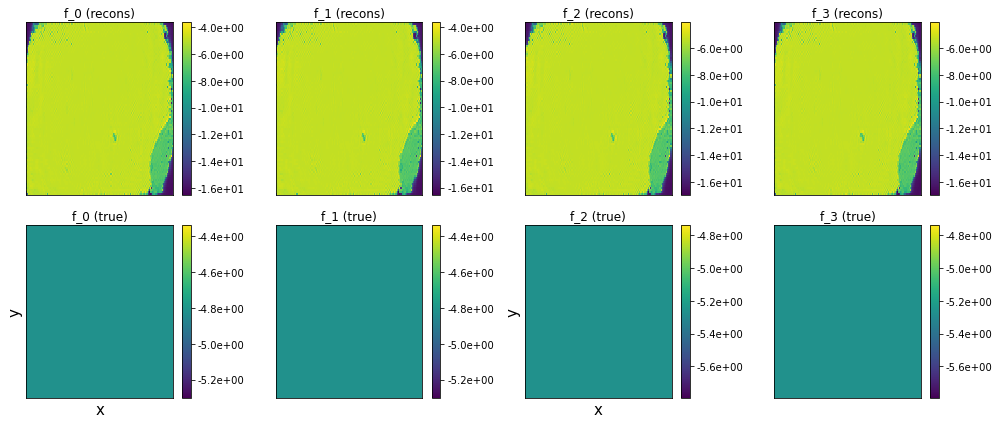

In [57]:
subplots_x = recons.rho_2d.shape[0] 
figsize_x = subplots_x * 3.5

fig, axs = plt.subplots(2, subplots_x, figsize=[figsize_x, 6]) 

for i in range(recons.rho_2d.shape[0]):
    recons_amplitudes = np.abs(recons.rho_2d[i][5:-5,5:-5])
    true_amplitudes = np.abs(recons._rho_true[i][5:-5,5:-5])
    
    cp0 = axs[0, i].pcolormesh(np.log(recons_amplitudes))
    axs[0, i].set_title(f"f_{i} (recons)")
    axs[0, i].set_xticks([])
    axs[0, i].set_yticks([])
    plt.colorbar(cp0, ax=axs[0, i], format="%.1e")
    
    cp1 = axs[1, i].pcolormesh(np.log(true_amplitudes))
    axs[1, i].set_title(f"f_{i} (true)")
    axs[1, i].set_xticks([])
    axs[1, i].set_yticks([])
    plt.colorbar(cp1, ax=axs[1, i], format="%.1e")
    
axs[1,0].set_xlabel('x', fontsize=15)
axs[1,0].set_ylabel('y', fontsize=15)

axs[1,2].set_xlabel('x', fontsize=15)
axs[1,2].set_ylabel('y', fontsize=15)


plt.tight_layout()
if save_plots:
    plt.savefig(f'{data_path}_recons_amplitudes.png', bbox_inches='tight')
plt.show()


In [58]:
recons.saveOutputsAndLog(data_path, prefix='direct_projected_')

In [33]:
!ls $data_path

direct_projected_df_displacement_to_data_shared_mags.gz
direct_projected_rho_displacement_to_data_shared_mags.npz
direct_projected_ux_displacement_to_data_shared_mags.npz
direct_projected_uy_displacement_to_data_shared_mags.npz
sample_point_inclusion.pkl
sim_point_inclusion.pkl


In [34]:
import pandas as pd

In [35]:
dload = pd.read_pickle(f'{data_path}/direct_projected_df_displacement_to_data_shared_mags.gz')

In [36]:
dload

,epoch,train_loss,err_ux,err_uy,err_ux_film,err_uy_film,err_rho0,err_rho1,err_rho2,err_rho3,err_rho_film0,err_rho_film1,err_rho_film2,err_rho_film3
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.0,206944.593750,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.0,226572.562500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.0,206152.265625,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.0,238338.265625,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
662,111.0,8091.377930,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
663,111.0,6840.916992,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
664,111.0,8628.835938,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
665,111.0,7674.362305,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [37]:
ux = recons_items[r'$\alpha_x$']
uy = recons_items[r'$\alpha_y$']

In [38]:
dux = np.gradient(ux)#, sm.sample.params.sample_pix_size)
duy = np.gradient(uy)#, sm.sample.params.sample_pix_size)
du = np.stack([dux, duy], axis=0)

In [39]:
sm.sample.params.lattice

array([0.0003905, 0.0003905, 0.0003905])

In [40]:

import matplotlib.colors as colors

<ipython-input-41-13f38f747939>:11: MatplotlibDeprecationWarning: default base will change from np.e to 10 in 3.4.  To suppress this warning specify the base keyword argument.
  im = axs[i * 2 + j].pcolormesh(sl, cmap=cmap,   norm=colors.SymLogNorm(linthresh=0.001, linscale=0.001,


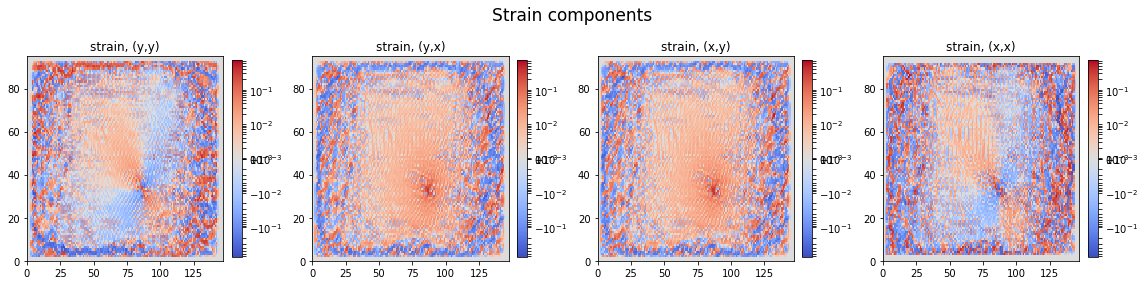

In [41]:
s = np.zeros(du.shape)
fig, axs = plt.subplots(1,4, figsize=(16,4))
coord_axes = {0:'y', 1:'x', 2:'z'}
for i in range(2):
    for j in range(2):
        s[i,j] = 0.5 * (du[j,i] + du[i,j]) #* sm.sample.params.lattice[0]
        # s[i,j][plots_3d_mask_trunc] = np.nan
        #s[i,j][~sm.sample.amplitudes_trunc_mask] = np.nan
        sl = s[i,j, :, :]
        sl = sl#[10:-10,10:-10]
        im = axs[i * 2 + j].pcolormesh(sl, cmap=cmap,   norm=colors.SymLogNorm(linthresh=0.001, linscale=0.001,
                                              vmin=-.75, vmax=0.75))
        axs[i * 2 + j].set_title(f'strain, ({coord_axes[i]},{coord_axes[j]})')
        plt.colorbar(im, ax=axs[2*i + j], fraction=0.046, pad=0.04)
plt.suptitle('Strain components', fontsize=17)
plt.tight_layout()

#if save_plots:
    #plt.savefig(f'{data_path}strain.pdf', bbox_inches='tight')
          
plt.show()  

In [42]:
s.max(), s.min()

(0.758537769317627, -0.902333676815033)

In [43]:
ux = true_items[r'$\alpha_x$']
uy = true_items[r'$\alpha_y$']

In [44]:
dux = np.gradient(ux)#, sm.sample.params.sample_pix_size)
duy = np.gradient(uy)#, sm.sample.params.sample_pix_size)
du = np.stack([dux, duy], axis=0)

<ipython-input-45-372bd4323cac>:11: MatplotlibDeprecationWarning: default base will change from np.e to 10 in 3.4.  To suppress this warning specify the base keyword argument.
  im = axs[i * 2 + j].pcolormesh(sl, cmap=cmap,   norm=colors.SymLogNorm(linthresh=0.001, linscale=0.001,


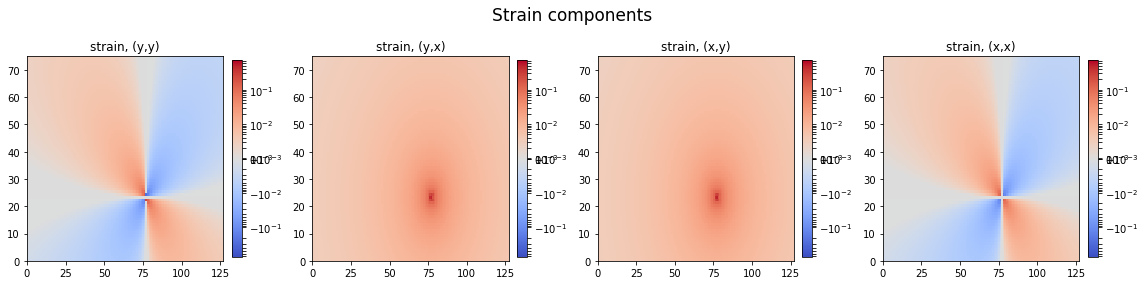

In [45]:
s = np.zeros(du.shape)
fig, axs = plt.subplots(1,4, figsize=(16,4))
coord_axes = {0:'y', 1:'x', 2:'z'}
for i in range(2):
    for j in range(2):
        s[i,j] = 0.5 * (du[j,i] + du[i,j]) #* sm.sample.params.lattice[0]
        # s[i,j][plots_3d_mask_trunc] = np.nan
        #s[i,j][~sm.sample.amplitudes_trunc_mask] = np.nan
        sl = s[i,j, :, :]
        sl = sl[10:-10,10:-10]
        im = axs[i * 2 + j].pcolormesh(sl, cmap=cmap,   norm=colors.SymLogNorm(linthresh=0.001, linscale=0.001,
                                              vmin=-0.75, vmax=0.75))
        axs[i * 2 + j].set_title(f'strain, ({coord_axes[i]},{coord_axes[j]})')
        plt.colorbar(im, ax=axs[2*i + j], fraction=0.046, pad=0.04)
plt.suptitle('Strain components', fontsize=17)
plt.tight_layout()

#if save_plots:
    #plt.savefig(f'{data_path}strain.pdf', bbox_inches='tight')
          
plt.show()  

In [102]:
sl.max()

0.14155861493467398

In [106]:
s.max(), s.min()

(0.512089098698885, -0.2560819462227913)